# Initializations

## imports

In [4]:
from torchvision.datasets import MNIST
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
import torchvision
from torch.autograd import Variable

import seaborn as sns
import numpy as np

from tqdm import tqdm

## configs

In [5]:
batch_size_train = 128
batch_size_test = 100
random_seed = 12453211

imbalanced_weights = {
    0: 0.1,
    1: 0.1,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 0.1,
    6: 1.0,
    7: 0.1,
    8: 1.0,
    9: 1.0
}

#2 → 7, 3 → 8, 5 ↔ 6 and 7 → 1 from SL paper
# Creating asymettric noise for 0,3,4 and 8
asymmetric_noise = {
    0: 0,
    1: 1,
    2: 7,
    3: 8,
    4: 4,
    5: 6,
    6: 5,
    7: 1,
    8: 8,
    9: 9
}

torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Data Preparation

## Loading torch dataset

In [6]:

train_set = torchvision.datasets.MNIST(
    '.',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_set = torchvision.datasets.MNIST(
    '.',
    train=False, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])
)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size_train,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size_test,
    shuffle=False
)

## loading numpy dataset

In [34]:
def data_loader_to_numpy(data_loader):
    result_x = []
    result_y = []
    for x, y in data_loader:
        result_x.append(x.numpy())
        result_y.append(y.numpy())
        
    return np.concatenate(result_x, axis=0), np.concatenate(result_y, axis=0)
    
train_x, train_y = data_loader_to_numpy(train_loader)
test_x, test_y = data_loader_to_numpy(test_loader)
valid_x, valid_y = data_loader_to_numpy(valid_loader)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(50000, 1, 28, 28) (10000, 1, 28, 28) (50000,) (10000,)


## distribution of classes

<AxesSubplot:ylabel='Count'>

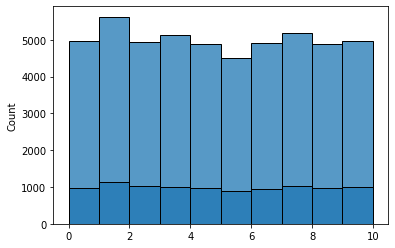

In [35]:
sns.histplot(train_y, bins=[i for i in range(11)])
sns.histplot(test_y, bins=[i for i in range(11)])

<AxesSubplot:>

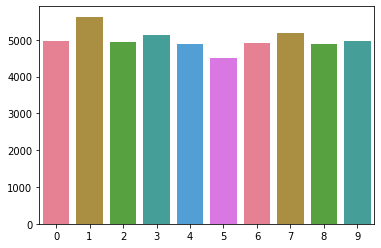

In [41]:
train_classes = [label for _, label in train_set]
data_count = Counter(train_classes)
palette = sns.color_palette("husl")
sns.barplot(x=list(data_count.keys()),y=list(data_count.values()),palette=palette)

tensor(9)


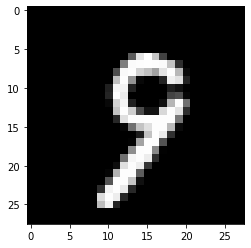

tensor(5)


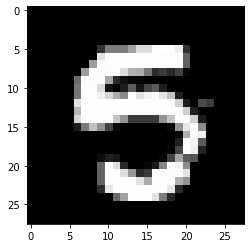

tensor(8)


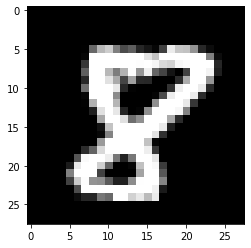

tensor(4)


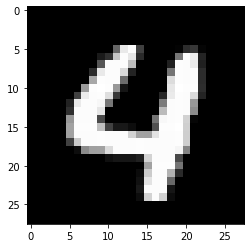

tensor(6)


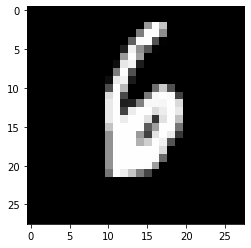

tensor(5)


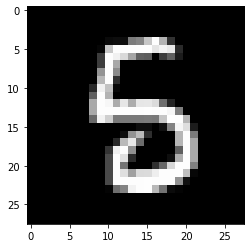

tensor(7)


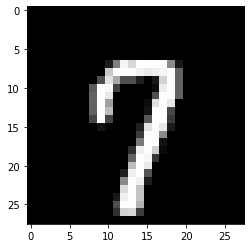

tensor(9)


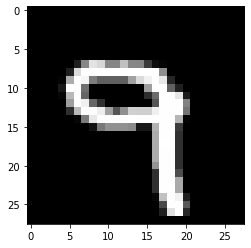

tensor(7)


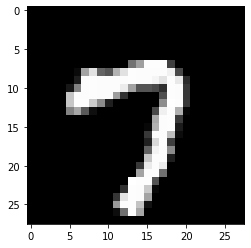

tensor(2)


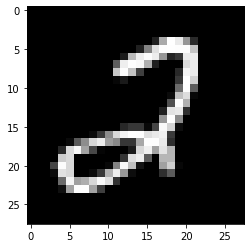

tensor(7)


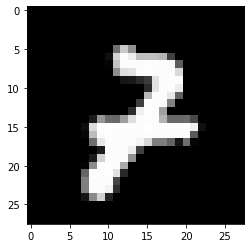

tensor(8)


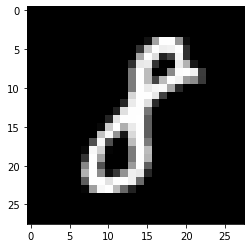

tensor(1)


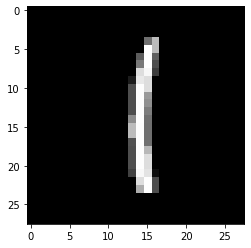

tensor(4)


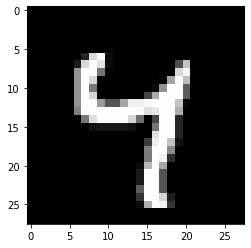

tensor(7)


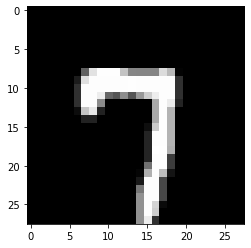

tensor(3)


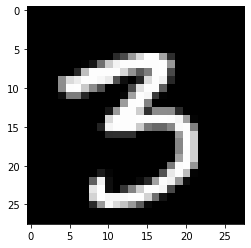

tensor(4)


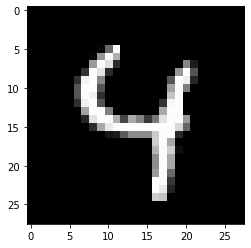

tensor(6)


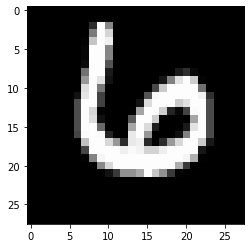

tensor(5)


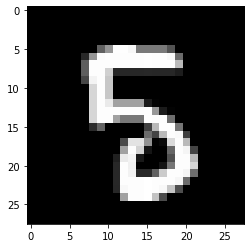

tensor(4)


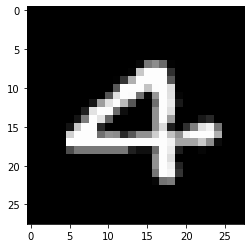

tensor(7)


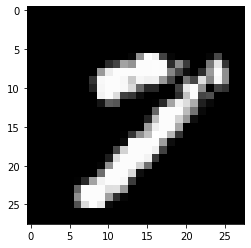

tensor(7)


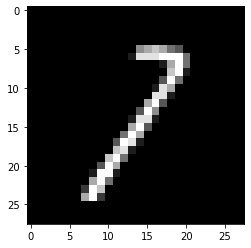

tensor(1)


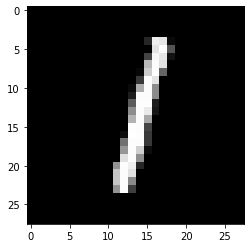

tensor(9)


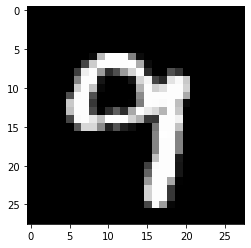

tensor(6)


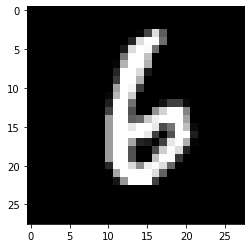

tensor(5)


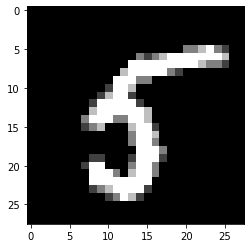

tensor(6)


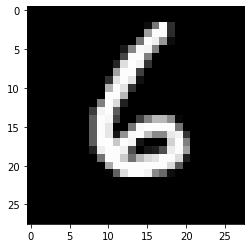

tensor(7)


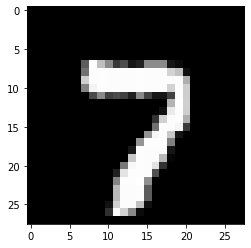

tensor(3)


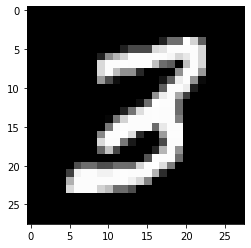

tensor(9)


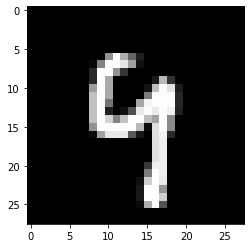

tensor(7)


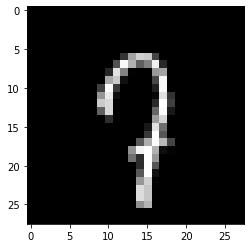

tensor(7)


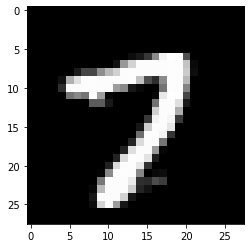

tensor(6)


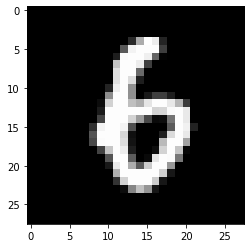

tensor(7)


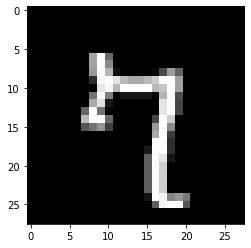

tensor(2)


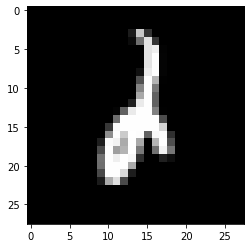

tensor(7)


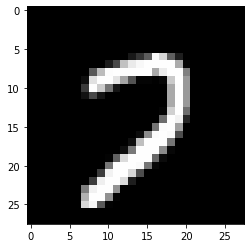

tensor(8)


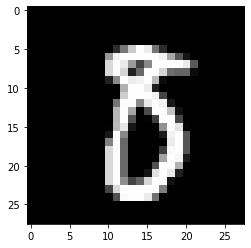

tensor(3)


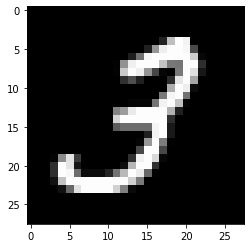

tensor(5)


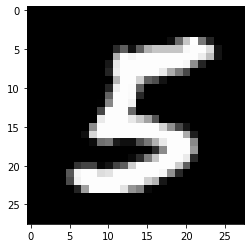

tensor(6)


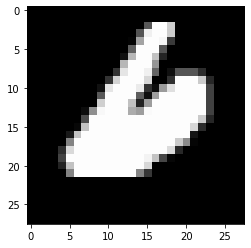

In [42]:
for index, (images,labels) in enumerate(train_loader):
    if index % 10 == 0:
        print(labels[1])
        plt.imshow(images[1].reshape(28,28), cmap="gray")
        plt.show()

## Creating imbalanced dataset

In [43]:
def make_imbalanced(ds_x, ds_y, imbalanced_weights=imbalanced_weights):
    class_partition = {k:[] for k in range(10)}

    for x, y in zip(ds_x, ds_y):
        class_partition[y].append((x, y))

    for i in range(10):
        idxs = np.random.randint(0, len(class_partition[i]), int(imbalanced_weights[i]*len(class_partition[i])))
        class_partition[i] = [class_partition[i][j] for j in idxs]
        print(f"class {i}: size={len(class_partition[i])}")

    imbalanced_train = []

    for partition in class_partition.values():
        imbalanced_train.extend(partition)

    np.random.shuffle(imbalanced_train)
    imbalanced_train_x, imbalanced_train_y = zip(*imbalanced_train)
    
    return imbalanced_train_x, imbalanced_train_y

imb_train_x, imb_train_y = make_imbalanced(train_x, train_y)

class 0: size=1488
class 1: size=1688
class 2: size=4942
class 3: size=5132
class 4: size=4894
class 5: size=1350
class 6: size=4908
class 7: size=1554
class 8: size=4891
class 9: size=4960


<AxesSubplot:ylabel='Count'>

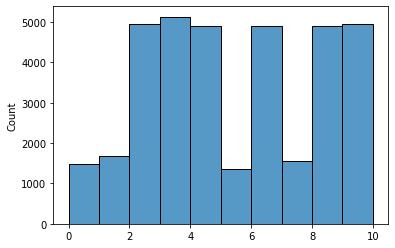

In [44]:
sns.histplot(imb_train_y, bins=[i for i in range(11)])

## create a dataset with symmetric noise

In [45]:
def apply_sym_noise(ds_x, ds_y, noise_ratio=0.3):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        if np.random.rand() <= noise_ratio:
            noisy_labels.append(np.random.randint(10))
        else:
            noisy_labels.append(y)

    return ds_x, np.array(noisy_labels)

x, y = apply_sym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

## create a dataset with asymmetric noise

In [56]:
def apply_asym_noise(ds_x, ds_y, asym_noise_map=asymmetric_noise, noise_ratio=0.3):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        if np.random.rand() <= noise_ratio:
            noisy_labels.append(asym_noise_map[y])
        else:
            noisy_labels.append(y)

    return ds_x, np.array(noisy_labels)

x, y = apply_asym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

# Generating All datasets

In [81]:
from torch.utils.data import TensorDataset

def generate_data_loader_from_np(_x, _y, batch_size_train=batch_size_train, valid_frac=0.1):
    tensor_x, tensor_y = torch.Tensor(np.array(_x)), torch.Tensor(np.array(_y)).long()
    train_set = TensorDataset(tensor_x, tensor_y)
    
    valid_size = int(len(train_set)*valid_frac)
    train_size = len(train_set) - valid_size
    
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size_train,
        shuffle=True
    )

    valid_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size_train,
        shuffle=True,
    )
    
    return train_loader, valid_loader


imb_train_loader, imb_valid_loader = generate_data_loader_from_np(imb_train_x, imb_train_y)


In [82]:
#balanced: train_x, train_y
#imbalanced: imb_train_x, imb_train_y
bal_sym_train_x, bal_sym_train_y = apply_sym_noise(train_x, train_y)
bal_asym_train_x, bal_asym_train_y = apply_asym_noise(train_x, train_y)
imb_sym_train_x, imb_sym_train_y = apply_sym_noise(imb_train_x, imb_train_y)
imb_asym_train_x, imb_asym_train_y = apply_asym_noise(imb_train_x, imb_train_y)

#balanced: train_loader
#imbalanced: imb_train_loader
bal_sym_train_loader, bal_sym_valid_loader = generate_data_loader_from_np(bal_sym_train_x, bal_sym_train_y)
bal_asym_train_loader, bal_asym_valid_loader = generate_data_loader_from_np(bal_asym_train_x, bal_asym_train_y)
imb_sym_train_loader, imb_sym_valid_loader = generate_data_loader_from_np(imb_sym_train_x, imb_sym_train_y)
imb_asym_train_loader, imb_asym_valid_loader = generate_data_loader_from_np(imb_asym_train_x, imb_asym_train_y)

<AxesSubplot:ylabel='Count'>

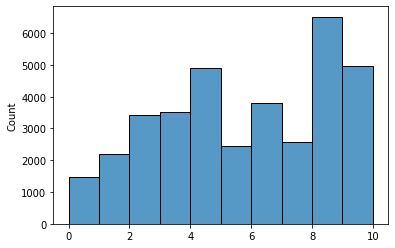

In [83]:
sns.histplot(imb_asym_train_y, bins=[i for i in range(11)])


# Models

## validation functions

### draw confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True)



In [25]:
from sklearn.metrics import classification_report

def clf_metrics(y_true, y_pred, n_class=10):
    class_names = [str(i) for i in range(n_class)]
    print(classification_report(y_true, y_pred, digits=4))
    


## SVM

### preprocessing data

In [ ]:
def preprocess(x, y):
    x, y = x.squeeze(), y
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

### model definition

In [ ]:
svm = SVC(
    kernel='linear',
    decision_function_shape='ovr',
    random_state=random_seed,
    verbose=True,
) 

svm.fit(train_x, train_y)
y_pred = svm.predict(test_x)

In [ ]:
svm.coef_.shape

In [ ]:
conf_mat(test_y, y_pred)

### model report

In [ ]:
clf_metrics(test_y, y_pred)

# Logistic Regression

## Model definition

In [ ]:
input_features = train_x[0].shape[1]
output_features = 10
num_epochs = 1

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_input_features, output_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_input_features, output_features)

    def forward(self, x):
        y_predicted = self.linear(x)
        return y_predicted


model = LogisticRegression(input_features * input_features, output_features)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


## Training the logistic regression model


In [ ]:
iter = 5

for epoch in range(num_epochs):
    for batch_number, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_features *
                             input_features).requires_grad_()
        labels = labels
         # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
         # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        batch_number += 1

## Testing the logistic regression model

In [ ]:
predictions = []
real_classes = []

for images, labels in test_loader:
    # Load images to a Torch Variable
    images = images.view(-1, 28*28).requires_grad_()

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.tolist()
    labels = labels.tolist()
    predictions.append(predicted)
    real_classes.append(labels)

predictions = [item for sublist in predictions for item in sublist]
real_classes = [item for sublist in real_classes for item in sublist]

## Confusion matrix and predictions for Logistic regression

In [ ]:
conf_mat(real_classes,predictions)
clf_metrics(real_classes,predictions)

## Saving the model

In [ ]:
torch.save(model.state_dict(), 'models/logistic.pkl')

# LDAM

In [76]:
from collections import Counter


def class_counter(data_loader):
    c = Counter()
    for _, batch_label in data_loader:
        c.update([int(x) for x in batch_label.numpy()])
    
    clist = [0]*10
    
    for cls, cnt in c.items():
        clist[cls] = cnt
        
    return clist

cls_num_list = class_counter(train_loader)

## define components

In [68]:
from resnet import resnet20, resnet32
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F


class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        #m_list = torch.tensor(m_list, dtype=torch.float)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        #index_float = torch.tensor(index, dtype=torch.float)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cls_num_list, device)
learning_rate = 1e-4
model = resnet32()
model.to(device)
criterion = LDAMLoss(cls_num_list)
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

[4963, 5627, 4942, 5132, 4894, 4503, 4908, 5180, 4891, 4960] cuda


## training 

In [ ]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")

def validate(model, criterion, valid_loader):
    
    losses = []
    preds = []
    y_true = []
    
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_true.extend(labels.cpu().numpy())
        predictions = model(images)
        preds.extend(predictions.cpu().numpy())
        
        loss = criterion(predictions, labels)
        losses.append(loss.detach().cpu().numpy())
        
    return np.array(preds), np.array(y_true), np.mean(losses)
        

def save_model(model, name):
    log(f"saving best model: {name}")
    torch.save(model.state_dict(), os.path.join('models', name))

        
def train_ldam(model, criterion, optimizer, train_loader, valid_loader, num_epochs, verbose=1, model_prefix='balanced-ldam'):
    
    log(f"{datetime.now()}: training ldam on {model_prefix}")
    best_loss = np.inf
    
    for epoch in range(1, num_epochs+1):
        
        model.train()
        epoch_losses = []
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        log(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO: keep best model
            
            model.eval()
            with torch.no_grad():
                valid_preds, valid_labels, valid_loss = validate(model, criterion, valid_loader)
                train_preds, train_labels, train_loss = validate(model, criterion, train_loader)
                
                train_pred_labels = np.argmax(train_preds, axis=1)
                valid_pred_labels = np.argmax(valid_preds, axis=1)
                
                log(f"training loss: {train_loss}, train accuracy: {accuracy_score(train_labels, train_pred_labels)}")
                log(f"validation loss: {valid_loss}, validation accuracy: {accuracy_score(valid_labels, valid_pred_labels)}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                save_model(model, f"{model_prefix}-{epoch}")
                
        
train_ldam(model, criterion, optimizer, train_loader, valid_loader, verbose=5, num_epochs=100)


## training on different datasets

In [ ]:
datasets = [
    (train_loader, valid_loader, 'balanced'),
    (imb_train_loader, imb_valid_loader, 'imbalanced'),
    (bal_sym_train_loader, bal_sym_valid_loader, 'bal_sym'),
    (bal_asym_train_loader, bal_asym_valid_loader, 'bal_asym'),
    (imb_sym_train_loader, imb_sym_valid_loader, 'imb_sym'),
    (imb_asym_train_loader, imb_asym_valid_loader, 'imb_asym'),
]

for train_loader, valid_loader, name in datasets:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cls_num_list = class_counter(train_loader)
    log(cls_num_list, device)
    learning_rate = 1e-4
    model = resnet32()
    model.to(device)
    criterion = LDAMLoss(cls_num_list)
    criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_ldam(model, criterion, optimizer, train_loader, valid_loader, verbose=5, num_epochs=100,
               model_prefix=f"ldam-{name}")
    

[1325, 1956, 3091, 3126, 4381, 2237, 3444, 2315, 5916, 4436]
2021-11-30 20:03:56.288123: training ldam on ldam-balanced


252it [00:05, 45.42it/s]


epoch 1, training loss: 21.04624366760254


252it [00:05, 45.22it/s]


epoch 2, training loss: 6.117005825042725


252it [00:05, 45.36it/s]


epoch 3, training loss: 5.294867038726807


252it [00:05, 45.27it/s]


epoch 4, training loss: 4.832450866699219


252it [00:05, 45.33it/s]


epoch 5, training loss: 4.507510662078857


100%|██████████| 252/252 [00:01<00:00, 166.19it/s]


training loss: 4.430034160614014, train accuracy: 0.8469606230800261
validation loss: 5.254753589630127, validation accuracy: 0.8298882681564246
saving best model: ldam-balanced-5


252it [00:05, 45.18it/s]


epoch 6, training loss: 4.22117805480957


252it [00:05, 45.34it/s]


epoch 7, training loss: 4.007910251617432


252it [00:05, 45.23it/s]


epoch 8, training loss: 3.7339515686035156


252it [00:05, 45.39it/s]


epoch 9, training loss: 3.5242128372192383


252it [00:05, 45.57it/s]


epoch 10, training loss: 3.234076499938965


100%|██████████| 252/252 [00:01<00:00, 168.30it/s]


training loss: 3.2746663093566895, train accuracy: 0.8940950134979986
validation loss: 5.66295862197876, validation accuracy: 0.8136871508379888


252it [00:05, 45.34it/s]


epoch 11, training loss: 3.0283873081207275


252it [00:05, 45.36it/s]


epoch 12, training loss: 2.8077352046966553


252it [00:05, 46.13it/s]


epoch 13, training loss: 2.613574266433716


252it [00:05, 45.46it/s]


epoch 14, training loss: 2.464578866958618


252it [00:05, 45.92it/s]


epoch 15, training loss: 2.363215923309326


100%|██████████| 252/252 [00:01<00:00, 169.51it/s]


training loss: 1.925346851348877, train accuracy: 0.9348062183883079
validation loss: 5.767783164978027, validation accuracy: 0.8083798882681564


252it [00:05, 45.90it/s]


epoch 16, training loss: 2.24172306060791


252it [00:05, 45.80it/s]


epoch 17, training loss: 2.176267623901367


252it [00:05, 45.96it/s]


epoch 18, training loss: 2.1069178581237793


252it [00:05, 47.26it/s]


epoch 19, training loss: 2.0865488052368164


252it [00:05, 45.90it/s]


epoch 20, training loss: 2.037125825881958


100%|██████████| 252/252 [00:01<00:00, 170.03it/s]


training loss: 2.1442277431488037, train accuracy: 0.9314860210382598
validation loss: 6.3578290939331055, validation accuracy: 0.7899441340782123


252it [00:05, 45.76it/s]


epoch 21, training loss: 2.029639482498169


252it [00:05, 45.63it/s]


epoch 22, training loss: 1.9978176355361938


252it [00:05, 45.18it/s]


epoch 23, training loss: 2.0004475116729736


252it [00:05, 45.37it/s]


epoch 24, training loss: 1.998976230621338


252it [00:05, 45.23it/s]


epoch 25, training loss: 1.9675990343093872


100%|██████████| 252/252 [00:01<00:00, 162.40it/s]


training loss: 1.7338114976882935, train accuracy: 0.9399261488813727
validation loss: 6.023441314697266, validation accuracy: 0.8047486033519553


252it [00:05, 45.03it/s]


epoch 26, training loss: 1.9869680404663086


252it [00:05, 44.99it/s]


epoch 27, training loss: 1.9554044008255005


252it [00:05, 44.98it/s]


epoch 28, training loss: 1.9423737525939941


252it [00:05, 44.98it/s]


epoch 29, training loss: 1.9352997541427612


252it [00:05, 44.73it/s]


epoch 30, training loss: 1.9487978219985962


100%|██████████| 252/252 [00:01<00:00, 161.60it/s]


training loss: 1.8280855417251587, train accuracy: 0.9398640891178205
validation loss: 6.1396942138671875, validation accuracy: 0.8016759776536313


252it [00:05, 44.89it/s]


epoch 31, training loss: 1.9508271217346191


252it [00:05, 45.79it/s]


epoch 32, training loss: 1.9159181118011475


252it [00:05, 45.23it/s]


epoch 47, training loss: 1.8882502317428589


252it [00:05, 45.63it/s]


epoch 48, training loss: 1.9020477533340454


252it [00:05, 45.43it/s]


epoch 49, training loss: 1.8803802728652954


252it [00:05, 45.33it/s]


epoch 50, training loss: 1.8751325607299805


100%|██████████| 252/252 [00:01<00:00, 165.97it/s]


training loss: 1.6911287307739258, train accuracy: 0.9402364476991343
validation loss: 6.154726982116699, validation accuracy: 0.7969273743016759


252it [00:05, 45.25it/s]


epoch 51, training loss: 1.874755859375


252it [00:05, 45.29it/s]


epoch 52, training loss: 1.8562194108963013


252it [00:05, 45.22it/s]


epoch 53, training loss: 1.8591697216033936


252it [00:05, 45.36it/s]


epoch 54, training loss: 1.8759161233901978


252it [00:05, 46.77it/s]


epoch 55, training loss: 1.8554657697677612


100%|██████████| 252/252 [00:01<00:00, 167.16it/s]


training loss: 1.5833759307861328, train accuracy: 0.9409501349799857
validation loss: 6.044131755828857, validation accuracy: 0.8022346368715084


252it [00:05, 48.17it/s]


epoch 56, training loss: 1.8509202003479004


252it [00:05, 48.27it/s]


epoch 57, training loss: 1.8718128204345703


252it [00:05, 48.38it/s]


epoch 58, training loss: 1.8620494604110718


252it [00:05, 48.37it/s]


epoch 59, training loss: 1.8604178428649902


252it [00:05, 48.37it/s]


epoch 60, training loss: 1.8549224138259888


100%|██████████| 252/252 [00:01<00:00, 171.40it/s]


training loss: 1.7740020751953125, train accuracy: 0.9396779098271636
validation loss: 5.863227844238281, validation accuracy: 0.8125698324022347


252it [00:05, 48.32it/s]


epoch 61, training loss: 1.8523626327514648


252it [00:05, 48.33it/s]


epoch 62, training loss: 1.865398645401001


252it [00:05, 48.06it/s]


epoch 63, training loss: 1.8546550273895264


252it [00:05, 46.17it/s]


epoch 64, training loss: 1.8369098901748657


252it [00:05, 46.02it/s]


epoch 65, training loss: 1.8337023258209229


100%|██████████| 252/252 [00:01<00:00, 168.43it/s]


training loss: 1.606418490409851, train accuracy: 0.941012194743538
validation loss: 6.047610282897949, validation accuracy: 0.7938547486033519


252it [00:05, 45.38it/s]


epoch 66, training loss: 1.8515585660934448


252it [00:05, 45.39it/s]


epoch 67, training loss: 1.8382428884506226


252it [00:05, 45.51it/s]


epoch 68, training loss: 1.8499140739440918


252it [00:05, 45.41it/s]


epoch 69, training loss: 1.8345956802368164


252it [00:05, 45.11it/s]


epoch 70, training loss: 1.851218819618225


100%|██████████| 252/252 [00:01<00:00, 162.56it/s]


training loss: 1.6144834756851196, train accuracy: 0.9409191050982095
validation loss: 5.905300140380859, validation accuracy: 0.8025139664804469


252it [00:05, 45.16it/s]


epoch 71, training loss: 1.8126376867294312


252it [00:05, 45.19it/s]


epoch 72, training loss: 1.841979742050171


252it [00:05, 45.16it/s]


epoch 73, training loss: 1.8210183382034302


252it [00:05, 45.27it/s]


epoch 74, training loss: 1.8234176635742188


252it [00:05, 45.72it/s]


epoch 75, training loss: 1.8426225185394287


100%|██████████| 252/252 [00:01<00:00, 170.90it/s]


training loss: 1.6365177631378174, train accuracy: 0.9411363142706426
validation loss: 5.863094329833984, validation accuracy: 0.8114525139664804


252it [00:05, 45.68it/s]


epoch 76, training loss: 1.818631887435913


252it [00:05, 45.66it/s]


epoch 77, training loss: 1.8108046054840088


252it [00:05, 45.77it/s]


epoch 78, training loss: 1.8162460327148438


252it [00:05, 45.66it/s]


epoch 79, training loss: 1.816123604774475


252it [00:05, 45.69it/s]


epoch 80, training loss: 1.8262488842010498


100%|██████████| 252/252 [00:01<00:00, 170.31it/s]


training loss: 1.5893406867980957, train accuracy: 0.9410432246253142
validation loss: 6.146890163421631, validation accuracy: 0.7927374301675978


252it [00:05, 45.09it/s]


epoch 81, training loss: 1.8216121196746826


252it [00:05, 45.19it/s]


epoch 82, training loss: 1.816353678703308


252it [00:05, 45.16it/s]


epoch 83, training loss: 1.8163760900497437


252it [00:05, 45.47it/s]


epoch 84, training loss: 1.818870186805725


252it [00:05, 45.55it/s]


epoch 85, training loss: 1.8164832592010498


100%|██████████| 252/252 [00:01<00:00, 165.59it/s]


training loss: 1.5711960792541504, train accuracy: 0.9412294039159711
validation loss: 5.866727352142334, validation accuracy: 0.8072625698324022


252it [00:05, 45.15it/s]


epoch 86, training loss: 1.8119004964828491


252it [00:05, 45.23it/s]


epoch 87, training loss: 1.82171630859375


252it [00:05, 45.18it/s]


epoch 88, training loss: 1.8127847909927368


252it [00:05, 45.06it/s]


epoch 89, training loss: 1.815938115119934


252it [00:05, 45.09it/s]


epoch 90, training loss: 1.8051645755767822


100%|██████████| 252/252 [00:01<00:00, 164.75it/s]


training loss: 1.5622169971466064, train accuracy: 0.9411983740341949
validation loss: 5.871931552886963, validation accuracy: 0.8092178770949721


252it [00:05, 45.55it/s]


epoch 91, training loss: 1.8133314847946167


252it [00:05, 45.55it/s]


epoch 92, training loss: 1.8171234130859375


252it [00:05, 45.45it/s]


epoch 93, training loss: 1.8074026107788086


252it [00:05, 45.46it/s]


epoch 94, training loss: 1.8005764484405518


252it [00:05, 45.10it/s]


epoch 95, training loss: 1.7979310750961304


100%|██████████| 252/252 [00:01<00:00, 164.74it/s]


training loss: 1.6939153671264648, train accuracy: 0.9408880752164335
validation loss: 5.8103508949279785, validation accuracy: 0.8150837988826816


252it [00:05, 45.44it/s]


epoch 96, training loss: 1.8018587827682495


252it [00:05, 45.55it/s]


epoch 97, training loss: 1.8023918867111206


175it [00:03, 44.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

252it [00:05, 45.49it/s]


epoch 99, training loss: 1.821873426437378


252it [00:05, 45.15it/s]


epoch 100, training loss: 1.7991234064102173


100%|██████████| 252/252 [00:01<00:00, 166.61it/s]


training loss: 1.5680956840515137, train accuracy: 0.9411983740341949
validation loss: 5.812888145446777, validation accuracy: 0.8170391061452514
[1342, 1515, 4416, 4612, 4392, 1227, 4406, 1400, 4445, 4472]
2021-11-30 20:13:43.309679: training ldam on ldam-imbalanced


252it [00:05, 45.61it/s]


epoch 1, training loss: 17.492717742919922


252it [00:05, 45.51it/s]


epoch 2, training loss: 1.5764997005462646


252it [00:05, 45.55it/s]


epoch 3, training loss: 0.9000754356384277


252it [00:05, 45.64it/s]


epoch 4, training loss: 0.5629661679267883


252it [00:05, 45.60it/s]


epoch 5, training loss: 0.3616507351398468


100%|██████████| 252/252 [00:01<00:00, 166.54it/s]


training loss: 0.21662260591983795, train accuracy: 0.994849039625159
validation loss: 0.5385425686836243, validation accuracy: 0.9849162011173185
saving best model: ldam-imbalanced-5


252it [00:05, 45.60it/s]


epoch 6, training loss: 0.23843510448932648


252it [00:05, 45.56it/s]


epoch 7, training loss: 0.15138855576515198


252it [00:05, 45.60it/s]


epoch 8, training loss: 0.09757700562477112


252it [00:05, 45.48it/s]


epoch 9, training loss: 0.05548764392733574


252it [00:05, 45.61it/s]


epoch 10, training loss: 0.0394585095345974


100%|██████████| 252/252 [00:01<00:00, 166.21it/s]


training loss: 0.019104117527604103, train accuracy: 0.9998758804728954
validation loss: 0.3633680045604706, validation accuracy: 0.9891061452513966
saving best model: ldam-imbalanced-10


252it [00:05, 45.51it/s]


epoch 11, training loss: 0.03097362071275711


252it [00:05, 45.75it/s]


epoch 12, training loss: 0.023643705993890762


252it [00:05, 45.76it/s]


epoch 13, training loss: 0.02211761847138405


252it [00:05, 45.80it/s]


epoch 14, training loss: 0.02050776779651642


252it [00:05, 45.79it/s]


epoch 15, training loss: 0.024637509137392044


100%|██████████| 252/252 [00:01<00:00, 167.34it/s]


training loss: 0.020874392241239548, train accuracy: 0.9998448505911193
validation loss: 0.3803921639919281, validation accuracy: 0.9879888268156425


252it [00:05, 45.77it/s]


epoch 16, training loss: 0.015565737150609493


252it [00:05, 45.81it/s]


epoch 17, training loss: 0.02606789395213127


252it [00:05, 45.77it/s]


epoch 18, training loss: 0.026070212945342064


252it [00:05, 45.79it/s]


epoch 19, training loss: 0.02033567987382412


252it [00:05, 45.65it/s]


epoch 20, training loss: 0.030619386583566666


100%|██████████| 252/252 [00:01<00:00, 166.61it/s]


training loss: 0.017713431268930435, train accuracy: 0.9998448505911193
validation loss: 0.3357284367084503, validation accuracy: 0.9910614525139665
saving best model: ldam-imbalanced-20


252it [00:05, 45.63it/s]


epoch 21, training loss: 0.018793579190969467


252it [00:05, 45.67it/s]


epoch 22, training loss: 0.013934065587818623


252it [00:05, 45.65it/s]


epoch 23, training loss: 0.01375720463693142


252it [00:05, 45.60it/s]


epoch 24, training loss: 0.016438890248537064


252it [00:05, 45.66it/s]


epoch 25, training loss: 0.018282106146216393


100%|██████████| 252/252 [00:01<00:00, 166.64it/s]


training loss: 0.02187209203839302, train accuracy: 0.9995655816551339
validation loss: 0.328744113445282, validation accuracy: 0.9916201117318436
saving best model: ldam-imbalanced-25


252it [00:05, 45.59it/s]


epoch 26, training loss: 0.027468934655189514


252it [00:05, 45.66it/s]


epoch 27, training loss: 0.022321602329611778


60it [00:01, 45.60it/s]

## load best model and test

In [14]:
def load_model(path):
    model = resnet32()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


model = load_model(os.path.join('models', 'balanced-70'))
model

ResNet_s(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [18]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

preds, y_true, loss = evaluate(test_loader, model)

100%|██████████| 79/79 [00:01<00:00, 44.57it/s]


## model report

In [26]:
clf_metrics(y_true, preds)

              precision    recall  f1-score   support

           0     0.9958    0.9969    0.9964       960
           1     0.9911    0.9964    0.9937      1115
           2     0.9960    0.9862    0.9911      1016
           3     0.9890    0.9910    0.9900       999
           4     0.9884    0.9863    0.9873       948
           5     0.9880    0.9858    0.9869       918
           6     0.9892    0.9960    0.9926      1010
           7     0.9872    0.9926    0.9899      1085
           8     0.9927    0.9896    0.9911       960
           9     0.9888    0.9838    0.9863       989

    accuracy                         0.9906     10000
   macro avg     0.9906    0.9905    0.9905     10000
weighted avg     0.9906    0.9906    0.9906     10000



# SCE

## defining components

In [30]:
import torch.nn as nn
import torch.nn.functional as F


class ConvBrunch(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super(ConvBrunch, self).__init__()
        padding = (kernel_size - 1) // 2
        self.out_conv = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_planes),
            nn.ReLU())

    def forward(self, x):
        return self.out_conv(x)


class SCEModel(nn.Module):
    def __init__(self):
        super(SCEModel, self).__init__()
        self.block1 = nn.Sequential(
            ConvBrunch(1, 64, 3),
            ConvBrunch(64, 64, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2 = nn.Sequential(
            ConvBrunch(64, 128, 3),
            ConvBrunch(128, 128, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.block3 = nn.Sequential(
            ConvBrunch(128, 196, 3),
            ConvBrunch(196, 196, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(
            nn.Linear(1764, 256),
            nn.BatchNorm1d(256),
            nn.ReLU())
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        # x = self.global_avg_pool(x)
        x = x.view(-1, 1764)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


## defining loss function

In [32]:
class SCELoss(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels):
        # CCE
        ce = self.cross_entropy(pred, labels)

        # RCE
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

        # Loss
        loss = self.alpha * ce + self.beta * rce.mean()
        return loss
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-4
sce_model = SCEModel()
sce_model.to(device)
sce_criterion = SCELoss(alpha=0.1, beta=1.0)
sce_criterion.to(device)
sce_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## training 

In [33]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")

def validate(model, criterion, valid_loader):
    
    losses = []
    preds = []
    y_true = []
    
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_true.extend(labels.cpu().numpy())
        predictions = model(images)
        preds.extend(predictions.cpu().numpy())
        
        loss = criterion(predictions, labels)
        losses.append(loss.detach().cpu().numpy())
        
    return np.array(preds), np.array(y_true), np.mean(losses)
        

def save_model(model, name):
    log(f"saving best model: {name}")
    torch.save(model.state_dict(), os.path.join('models', name))

        
def train_sce(model, criterion, optimizer, train_loader, valid_loader, num_epochs, verbose=1, model_prefix='balanced_sce'):
    
    log(f"{datetime.now()}: training sce on {model_prefix}")
    best_loss = np.inf
    
    for epoch in range(1, num_epochs+1):
        
        model.train()
        epoch_losses = []
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        log(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO: keep best model
            
            model.eval()
            with torch.no_grad():
                valid_preds, valid_labels, valid_loss = validate(model, criterion, valid_loader)
                train_preds, train_labels, train_loss = validate(model, criterion, train_loader)
                
                train_pred_labels = np.argmax(train_preds, axis=1)
                valid_pred_labels = np.argmax(valid_preds, axis=1)
                
                log(f"training loss: {train_loss}, train accuracy: {accuracy_score(train_labels, train_pred_labels)}")
                log(f"validation loss: {valid_loss}, validation accuracy: {accuracy_score(valid_labels, valid_pred_labels)}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                save_model(model, f"{model_prefix}-{epoch}")
                
        
train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=100)


2021-11-30 19:11:32.080020: training sce on balanced


391it [00:09, 41.55it/s]


epoch 1, training loss: 8.581124305725098


153it [00:03, 41.47it/s]


KeyboardInterrupt: 

## load best model and test

In [14]:
def load_model(path):
    model = resnet32()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


model = load_model(os.path.join('models', 'balanced-70'))
model

ResNet_s(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [18]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

preds, y_true, loss = evaluate(test_loader, model)

100%|██████████| 79/79 [00:01<00:00, 44.57it/s]


## model report

In [26]:
clf_metrics(y_true, preds)

              precision    recall  f1-score   support

           0     0.9958    0.9969    0.9964       960
           1     0.9911    0.9964    0.9937      1115
           2     0.9960    0.9862    0.9911      1016
           3     0.9890    0.9910    0.9900       999
           4     0.9884    0.9863    0.9873       948
           5     0.9880    0.9858    0.9869       918
           6     0.9892    0.9960    0.9926      1010
           7     0.9872    0.9926    0.9899      1085
           8     0.9927    0.9896    0.9911       960
           9     0.9888    0.9838    0.9863       989

    accuracy                         0.9906     10000
   macro avg     0.9906    0.9905    0.9905     10000
weighted avg     0.9906    0.9906    0.9906     10000

